## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "BASE_MODEL_PATH": 'imagenet',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 30,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 5,
 'BASE_MODEL_PATH': 'imagenet',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [7]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

# Model

In [8]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get('resnet18')
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_PATH'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 1e-06


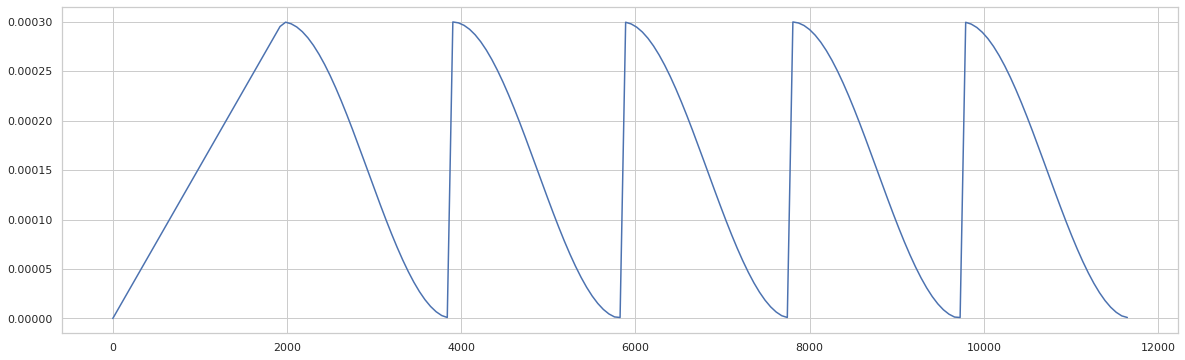

In [9]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 25000 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
hold_max_steps = 0
warmup_steps = steps_per_epoch * 5
num_cycles = 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [cosine_with_hard_restarts_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                                    warmup_steps=warmup_steps, lr_start=lr_start, 
                                                    lr_max=lr_max, lr_min=lr_min, num_cycles=num_cycles) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Training

In [10]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    steps_per_epoch = train_size // config['BATCH_SIZE']

    # Train model
    model_path = f'model_fold_{n_fold}.h5'
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: cosine_with_hard_restarts_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                    total_steps=total_steps, warmup_steps=warmup_steps, 
                                                                    lr_start=lr_start, lr_max=lr_max, lr_min=lr_min, 
                                                                    num_cycles=num_cycles)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        optimizer = tfa.optimizers.SWA(optimizer, start_averaging=int(steps_per_epoch * 5), average_period=int(steps_per_epoch * 5))

        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=steps_per_epoch,
                        verbose=2).history
    
    model.save_weights(model_path)
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
44924928/44920640 [==============================] - 4s 0us/step
Epoch 1/30
388/388 - 129s - loss: 0.3380 - auc: 0.5736 - val_loss: 0.2366 - val_auc: 0.4912
Epoch 2/30
388/388 - 130s - loss: 0.1712 - auc: 0.7848 - val_loss: 0.1736 - val_auc: 0.6640
Epoch 3/30
388/388 - 130s - loss: 0.1694 - auc: 0.8103 - val_loss: 0.1787 - val_auc: 0.6071
Epoch 4/30
388/388 - 130s - loss: 0.1688 - auc: 0.8279 - val_loss: 0.1858 - val_auc: 0.8472
Epoch 5/30
388/388 - 127s - loss: 0.1675 - auc: 0.8320 - val_loss: 0.1727 - val_auc: 0.8058
Epoch 6/30
388/388 - 118s - loss: 0.1679 - auc: 0.8411 - val_loss: 0.1738 - val_auc: 0.8245
Epoch 7/30
388/388 - 120s - loss: 0.1645 - auc: 0.8632 - val_loss: 0.1636 - val_auc: 0.8704
Epoch 8/30
388/388 - 118s - loss: 0.1640 - auc: 0.8717 - val_loss: 0.1633 - val_auc: 0.8609
Epoch 9/30
388/388 - 120s - loss: 0.1602 - auc: 0.9139 - val_loss: 0.1629 - val_auc: 0.8730
Epoch 10/30
388/388 - 119s - loss: 0.1568 - auc: 0.9344 - val_loss: 0.1627 - val_auc: 0.8638
Epoch

## Model loss graph

Fold: 1


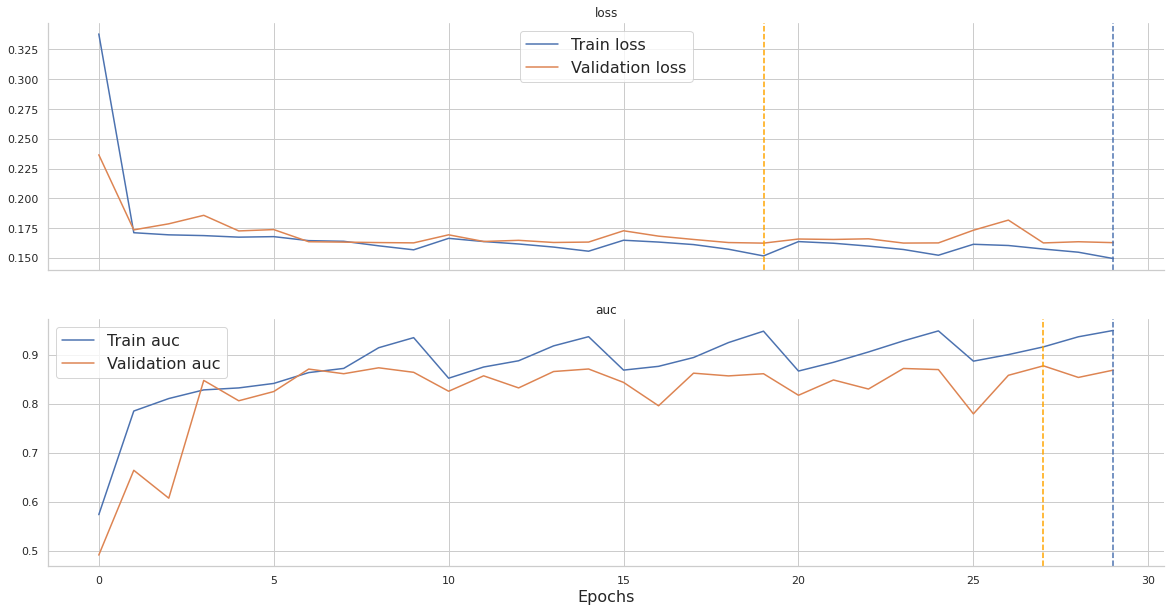

Fold: 2


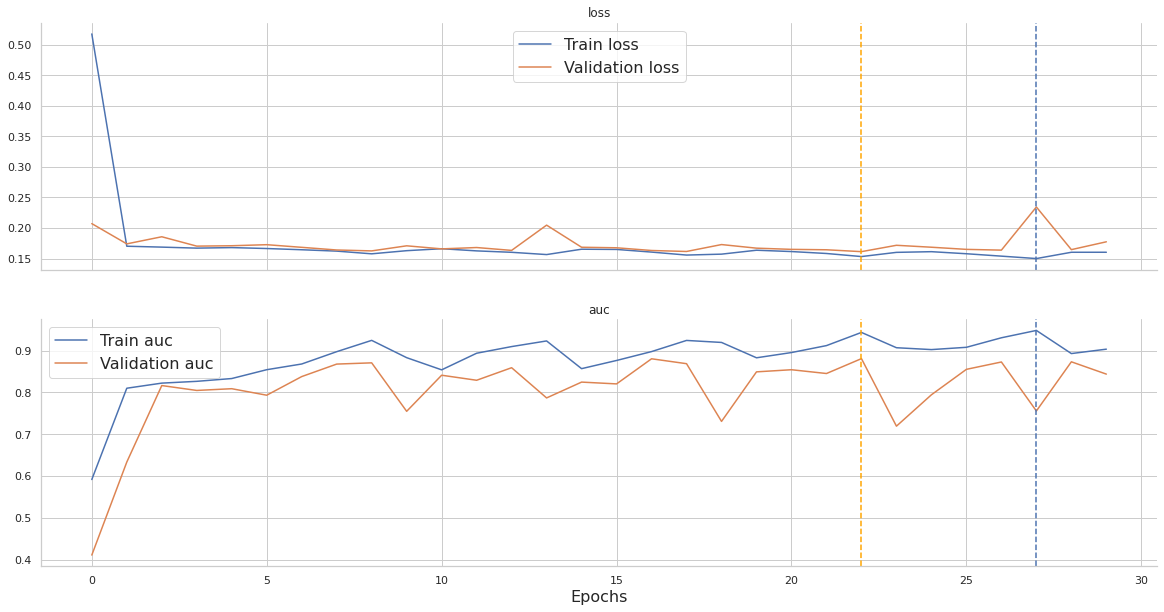

Fold: 3


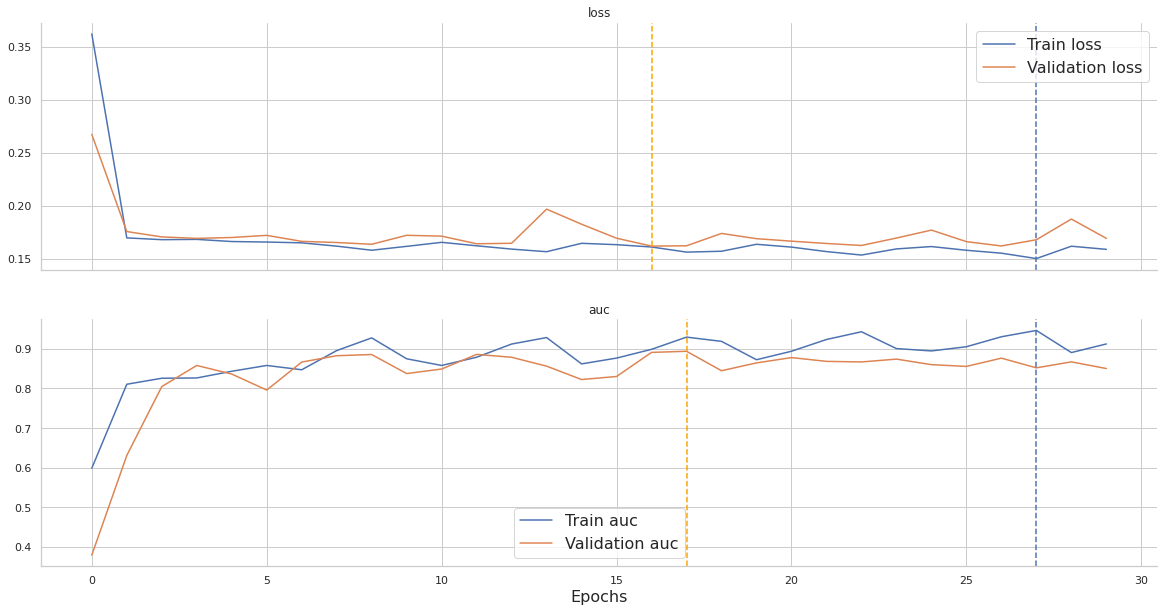

Fold: 4


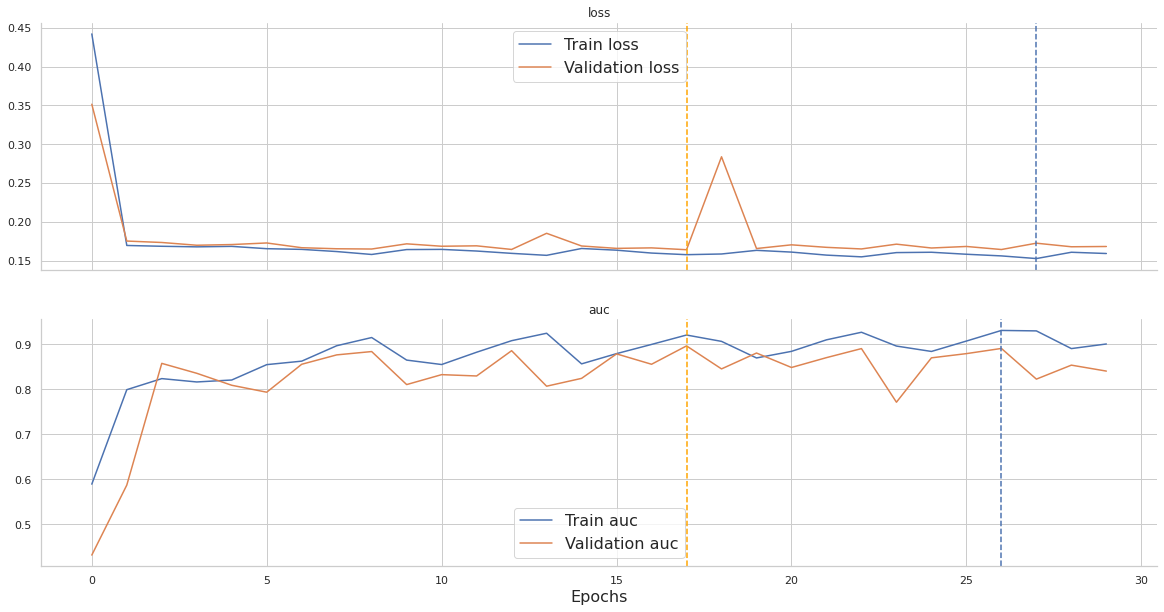

Fold: 5


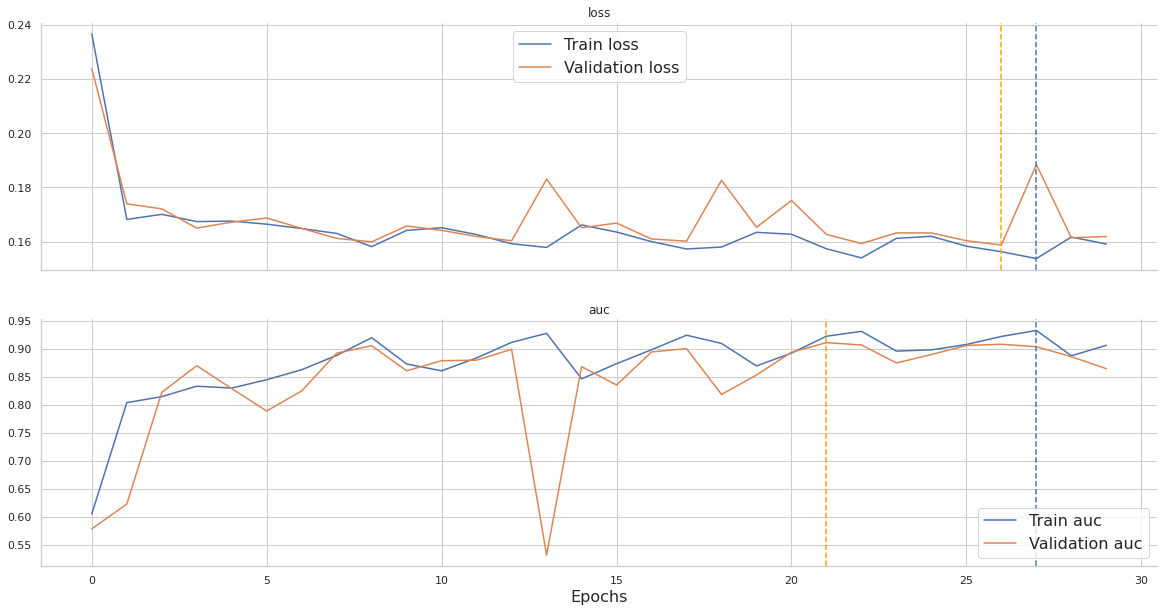

In [11]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

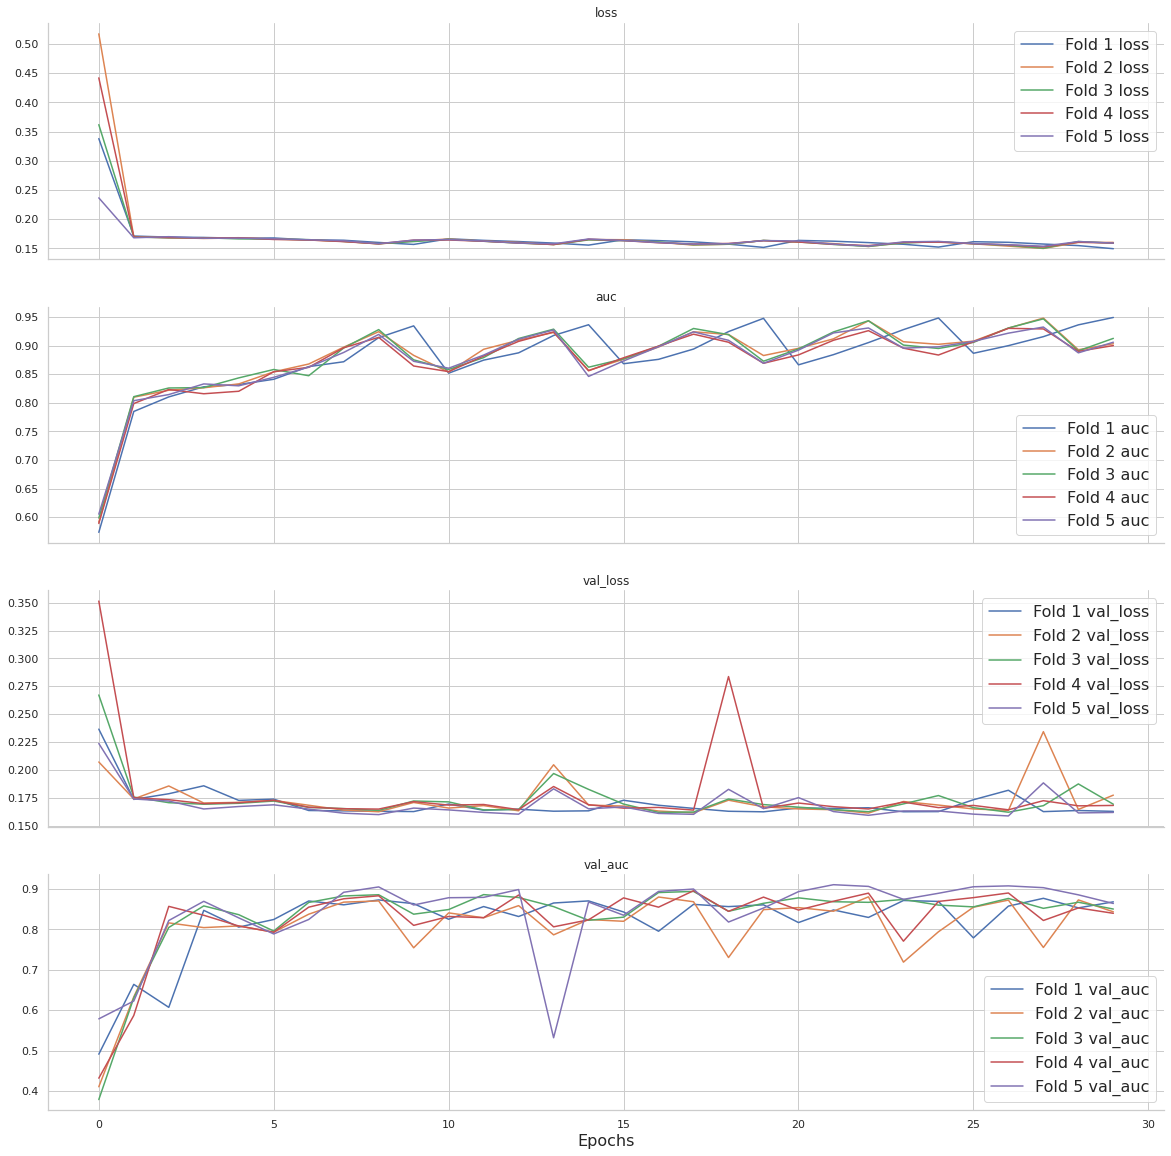

In [12]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [13]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.931988,0.854173,0.077814,0.971941,0.868779,0.918193,0.841732,0.922279,0.852858,0.915835,0.842823,0.931691,0.864675
Accuracy,0.984454,0.980430,0.004024,0.989333,0.981048,0.981013,0.976018,0.984134,0.980364,0.983397,0.981944,0.984394,0.982778
Precision,0.768272,0.396619,0.371654,0.893805,0.333333,0.442006,0.232877,0.619565,0.371429,0.903226,0.500000,0.982759,0.545455
Recall,0.234912,0.091296,0.143616,0.455982,0.113475,0.297468,0.154545,0.242038,0.115044,0.059322,0.017857,0.119748,0.055556
F1-score,0.326481,0.133221,0.193260,0.603886,0.169312,0.355612,0.185792,0.348092,0.175676,0.111332,0.034483,0.213483,0.100840
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [14]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.931988,0.854173,0.077814,0.971941,0.868779,0.918193,0.841732,0.922279,0.852858,0.915835,0.842823,0.931691,0.864675
male,0.927609,0.845718,0.081891,0.970509,0.880176,0.914604,0.813815,0.915051,0.849845,0.909475,0.814798,0.928407,0.869957
female,0.936080,0.860763,0.075317,0.973662,0.848240,0.920717,0.874124,0.929387,0.846636,0.923037,0.873585,0.933596,0.861232
head/neck,0.925672,0.813544,0.112128,0.953560,0.875465,0.899468,0.729900,0.926108,0.820433,0.913285,0.809857,0.935939,0.832063
upper extremity,0.928408,0.851607,0.076801,0.971164,0.838428,0.887829,0.870885,0.926664,0.835928,0.911362,0.876141,0.945019,0.836652
lower extremity,0.911837,0.802746,0.109091,0.971081,0.812586,0.898213,0.812100,0.873785,0.777568,0.890209,0.823826,0.925897,0.787652
torso,0.941480,0.882267,0.059213,0.974400,0.905221,0.938119,0.871093,0.939286,0.885999,0.928206,0.849832,0.927387,0.899191
0 <= age < 26,0.858326,0.698844,0.159483,0.929875,0.791958,0.709367,0.689095,0.877397,0.618106,0.881607,0.811354,0.893385,0.583705
26 <= age < 40,0.918876,0.824212,0.094665,0.961528,0.840193,0.915895,0.804074,0.923478,0.743095,0.908830,0.844212,0.884650,0.889482


# Confusion matrix

Fold: 1


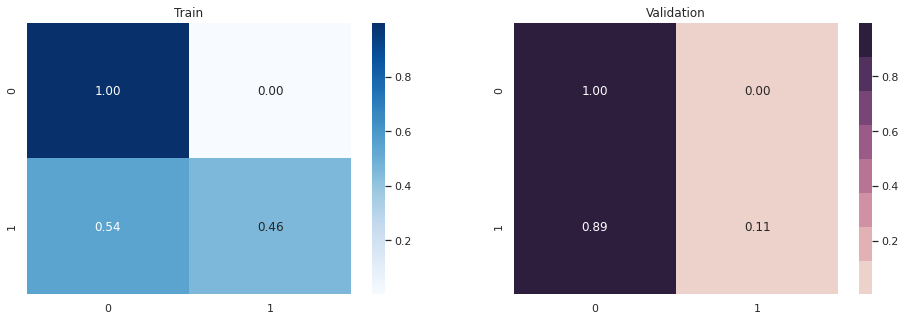

Fold: 2


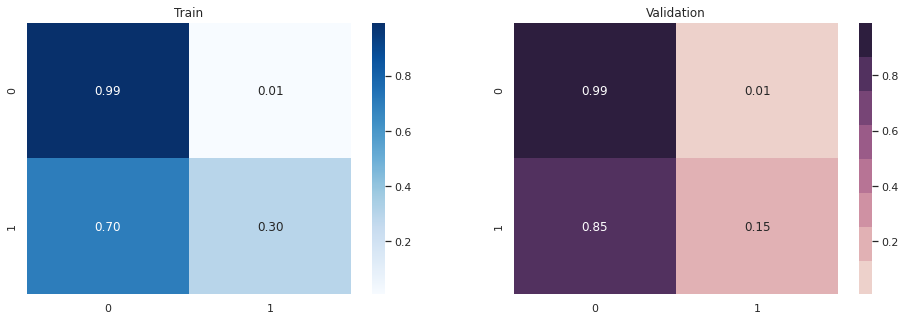

Fold: 3


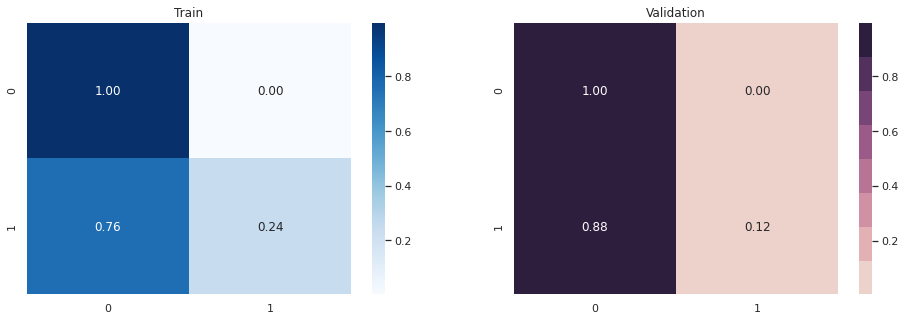

Fold: 4


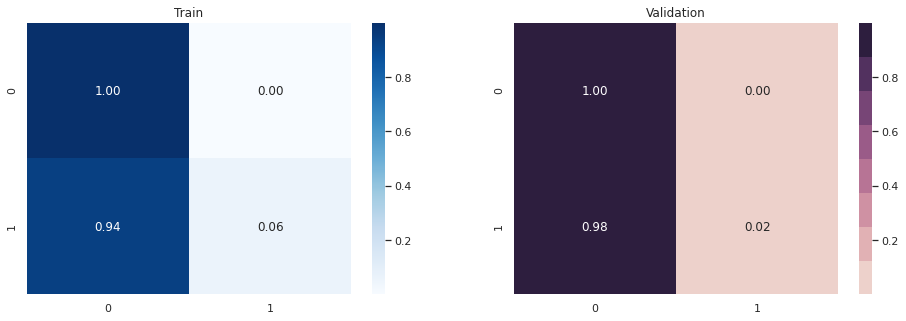

Fold: 5


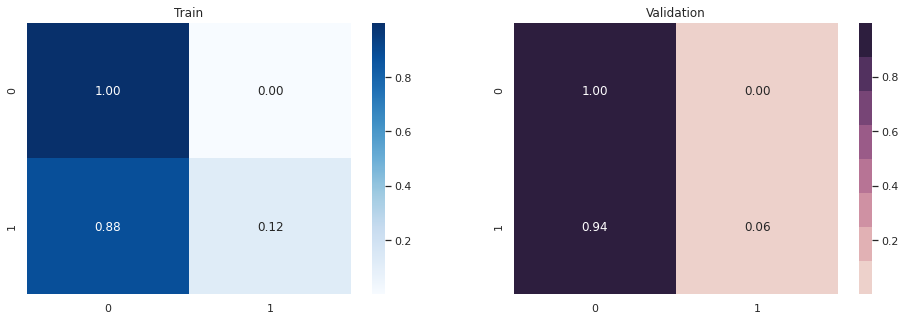

In [15]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [16]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.030215,0.024334,0.050530,0.027011,0.020370,0.028831
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.023213,0.026867,0.020366,0.024417,0.021479,0.022935
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.023938,0.019907,0.023677,0.023141,0.030107,0.022859
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.032757,0.025486,0.029009,0.032416,0.047264,0.029608
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.024912,0.021984,0.024067,0.024810,0.032459,0.021242
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024656,0.025553,0.034007,0.022483,0.019180,0.022058
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.045345,0.028397,0.090085,0.041586,0.029630,0.037029
7,ISIC_0075663,female,35.0,torso,unknown,0,0.037178,0.025308,0.031653,0.069017,0.019453,0.040458
8,ISIC_0075914,male,30.0,torso,unknown,0,0.025413,0.025377,0.026420,0.027225,0.025197,0.022849
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.028969,0.023019,0.035937,0.040065,0.017825,0.028002


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.055958,0.024617,0.029261,0.033897,0.032686,0.159330
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.261177,0.056906,0.740805,0.280541,0.087003,0.140628
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.289044,0.920935,0.284138,0.063883,0.049781,0.126485
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.079748,0.095099,0.065722,0.110205,0.079439,0.048275
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.148069,0.320257,0.142929,0.101620,0.035627,0.139913
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.292719,0.949824,0.106526,0.079906,0.035059,0.292282
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.103492,0.185711,0.097036,0.139579,0.041385,0.053751
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.236188,0.194446,0.464440,0.161155,0.082444,0.278457
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.107090,0.054041,0.109581,0.198034,0.137248,0.036545
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.294917,0.784861,0.319526,0.044519,0.093950,0.231727


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
1205,ISIC_0464315,male,70.0,torso,unknown,0,0.554989,0.870089,0.668717,0.628047,0.467621,0.140473
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.746007,0.969169,0.849169,0.870830,0.355413,0.685456
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.652641,0.897237,0.708012,0.771674,0.224646,0.661635
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.561686,0.938322,0.593464,0.437895,0.671881,0.166866
1654,ISIC_0599605,male,70.0,upper extremity,melanoma,1,0.522389,0.665082,0.908995,0.664812,0.264728,0.108328
2753,ISIC_0924427,male,65.0,head/neck,melanoma,1,0.648197,0.904823,0.791362,0.761155,0.402815,0.380831
3028,ISIC_1009042,male,70.0,torso,melanoma,1,0.552865,0.987841,0.322508,0.568526,0.398483,0.486965
3204,ISIC_1068686,male,55.0,torso,melanoma,1,0.526367,0.671672,0.766360,0.610633,0.231238,0.351931
3409,ISIC_1132496,male,70.0,torso,melanoma,1,0.517527,0.723607,0.835218,0.781305,0.045041,0.202462
3689,ISIC_1210011,male,75.0,torso,melanoma,1,0.644568,0.976390,0.502765,0.839438,0.544701,0.359544


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 105
Train positive correct predictions: 97


# Make predictions

In [17]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


In [18]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/kaggle/working/model_fold_1.h5
/kaggle/working/model_fold_2.h5
/kaggle/working/model_fold_3.h5
/kaggle/working/model_fold_4.h5
/kaggle/working/model_fold_5.h5


# Visualize test predictions

In [19]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 18|10964
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.039291
1,ISIC_0052349,male,40.0,lower extremity,0.022062
2,ISIC_0058510,female,55.0,torso,0.023537
3,ISIC_0073313,female,50.0,torso,0.022003
4,ISIC_0073502,female,45.0,lower extremity,0.055348
5,ISIC_0074618,male,50.0,lower extremity,0.040739
6,ISIC_0076801,male,45.0,upper extremity,0.023665
7,ISIC_0077586,male,50.0,lower extremity,0.097396
8,ISIC_0082004,female,45.0,torso,0.076080
9,ISIC_0082785,male,65.0,lower extremity,0.045901


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
42,ISIC_0155983,male,70.0,torso,0.518286
522,ISIC_0585534,male,70.0,head/neck,0.536629
1408,ISIC_1364884,female,35.0,upper extremity,0.557295
2116,ISIC_2002073,male,40.0,upper extremity,0.625539
2195,ISIC_2078598,male,80.0,torso,0.531061
2739,ISIC_2560699,male,70.0,torso,0.690268
3045,ISIC_2839742,male,70.0,upper extremity,0.743477
3103,ISIC_2900150,female,80.0,lower extremity,0.539424
4332,ISIC_4000026,male,90.0,torso,0.572767
5424,ISIC_4975524,male,75.0,torso,0.577507


# Test set predictions

In [20]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.039291
1,ISIC_0052349,0.022062
2,ISIC_0058510,0.023537
3,ISIC_0073313,0.022003
4,ISIC_0073502,0.055348
5,ISIC_0074618,0.040739
6,ISIC_0076801,0.023665
7,ISIC_0077586,0.097396
8,ISIC_0082004,0.076080
9,ISIC_0082785,0.045901


,target
count,10982.000000
mean,0.052831
std,0.055335
min,0.014050
25%,0.026090
50%,0.033690
75%,0.053835
max,0.743477
